# 09. PyTorch Model Deployment

ML model deployment is the act of making your machine learning model(s) available to someone or something else.

## 0. Get setup

In [ ]:
try:
  import torch
  import torchvision
  from torch import nn
  assert int(torch.__version__.split('.')[0]) >= 2, 'Upgrade torch'
  assert int(torchvision.__version__.split('.')[1]) >= 13, 'Upgrade torchvision'
  print('torch', torch.__version__)
  print(f'torchvision {torchvision.__version__}')
except:
  !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu121
  import torch
  import torchvision
  print(f'torch {torch.__version__}')
  print(f'torchvision {torchvision.__version__}')

torch 2.4.1+cu121
torchvision 0.19.1+cu121


In [ ]:
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning.git
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 255 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

In [ ]:
import requests
from pathlib import Path
from zipfile import ZipFile

data_path = Path('data')

if not data_path.is_dir():
  print('Is downloading')
  zip_file = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip')
  with open('data.zip', 'wb') as f:
    f.write(zip_file.content)

  with ZipFile('data.zip') as f:
    f.extractall(data_path)

if Path('data.zip').exists():
  !rm data.zip

Is downloading


In [ ]:
train_dir = data_path / 'train'
test_dir = data_path / 'test'

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

* Performs well: 95% accuracy
* Fast: real-time = 30FPS+ = 30ms latency
  * Latency: time for prediction to take place

## 3. Creating an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes:int = 3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=weights)
  for param in effnetb2.parameters():
    param.requires_grad = False

  set_seeds(seed)
  effnetb2.classifier = torch.nn.Sequential(nn.Dropout(p=0.3),
                                            nn.Linear(1408, num_classes))

  return effnetb2, effnetb2_transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 93.9MB/s]


In [ ]:
summary(model=effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'])

In [ ]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir, test_dir, effnetb2_transforms, batch_size=32)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

(15, 5)

### 3.3 Training EffNetB2 feature extractor

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                       train_dataloader=train_dataloader_effnetb2,
                       test_dataloader=test_dataloader_effnetb2,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9721 | train_acc: 0.5646 | test_loss: 0.7355 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7212 | train_acc: 0.8458 | test_loss: 0.5855 | test_acc: 0.9381
Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8583 | test_loss: 0.4873 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9021 | test_loss: 0.4301 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4347 | train_acc: 0.8938 | test_loss: 0.3884 | test_acc: 0.9352
Epoch: 6 | train_loss: 0.4180 | train_acc: 0.8875 | test_loss: 0.3501 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4243 | train_acc: 0.8708 | test_loss: 0.3241 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.3842 | train_acc: 0.8958 | test_loss: 0.3380 | test_acc: 0.9506
Epoch: 9 | train_loss: 0.3724 | train_acc: 0.8958 | test_loss: 0.3086 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3547 | train_acc: 0.8604 | test_loss: 0.2801 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

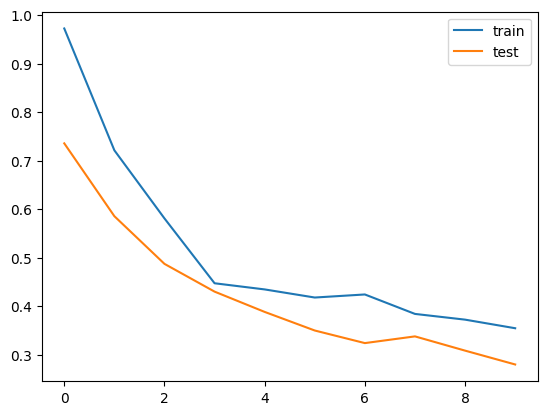

In [ ]:
import matplotlib.pyplot as plt
x = range(0, 10)
plt.plot(x, effnetb2_results['train_loss'], label='train')
plt.plot(x, effnetb2_results['test_loss'], label='test')
plt.legend()

In [ ]:
torch.save(effnetb2, 'effnetb2.pth')

### 3.6 Inspecting the size of EffNetB2 feature extractor

In [ ]:
from pathlib import Path

effnetb2_size = Path('effnetb2.pth').stat().st_size / (1024**2)
print(f'{round(effnetb2_size, 2)} MB')

29.9 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'num_of_parameters': effnetb2_total_params,
                  'model_size (MB)': effnetb2_size}

effnetb2_stats

{'test_loss': 0.28009578585624695,
 'test_acc': 0.9625,
 'num_of_parameters': 7705221,
 'model_size (MB)': 29.9033145904541}

## 4. Creating a ViT feature extractor

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  vit_transform = vit_weights.transforms()
  vit = torchvision.models.vit_b_16(weights=vit_weights)

  for param in vit.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  vit.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

  return vit, vit_transform

In [ ]:
vit, vit_transform = create_vit_model()
vit_transform

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 154MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
train_dataloader_vit, test_dataloader_vit, num_classes = data_setup.create_dataloaders(train_dir,
                                                                                       test_dir,
                                                                                       vit_transform,
                                                                                       32)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

set_seeds()
vit_results = engine.train(vit,
                          train_dataloader_vit,
                          test_dataloader_vit,
                          optimizer,
                          loss_fn,
                          10,
                          device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


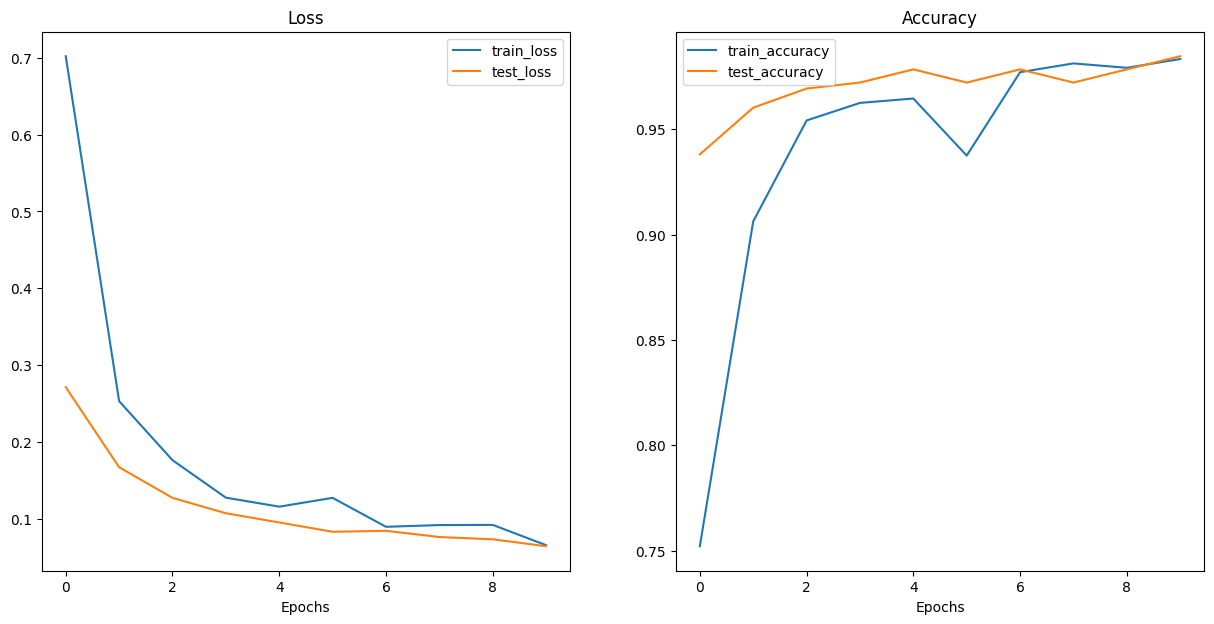

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
torch.save(vit, 'vit.pth')

In [ ]:
from pathlib import Path
vit_size = Path('vit.pth').stat().st_size / (1024**2)

print(f'Vit size: {round(vit_size, 2)} MB')

Vit size: 327.38 MB


In [ ]:
vit_params = sum(torch.numel(param) for param in vit.parameters())

In [ ]:
vit_stat = {'test_loss': vit_results['test_loss'][-1],
            'test_acc': vit_results['test_acc'][-1],
            'num_of_parameters':vit_params,
            'model_size (MB)': vit_size}

vit_stat

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'num_of_parameters': 85800963,
 'model_size (MB)': 327.37532234191895}

In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

### 5.1 Creating a function to make across the test dataset

In [ ]:
from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm

def pred_and_store(paths:List[Path],
                   model:nn.modules,
                   transform:torchvision.transforms,
                   class_names: List[str],
                   device:str) -> List[Dict]:

  model.eval()
  with torch.inference_mode():
    preds = []
    for path in tqdm(paths):
      pred_dict = {}
      pred_dict['image_path'] = path
      gt = path.parent.stem
      pred_dict['class_name'] = gt

      start_time = timer()
      image = Image.open(path)
      image = transform(image).to(device).unsqueeze(0)
      model = model.to(device)

      pred = torch.argmax(torch.softmax(model(image), dim=1), dim=1).item()
      pred_dict['pred_prob'] = round(pred, 2)
      pred_dict['pred_class'] = class_names[pred]

      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time - start_time, 4)
      pred_dict['correct'] = pred_dict['pred_class'] == gt

      preds.append(pred_dict)

  return preds


In [ ]:
effnetb2_preds = pred_and_store(test_data_paths,
                                model=effnetb2,
                                transform=effnetb2_transforms,
                                class_names=class_names,
                                device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn the test pred dicts into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_preds)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/test/pizza/1687143.jpg,pizza,0,pizza,0.4429,True
1,data/test/pizza/1555015.jpg,pizza,0,pizza,0.1081,True
2,data/test/pizza/648055.jpg,pizza,0,pizza,0.1123,True
3,data/test/pizza/3375083.jpg,pizza,0,pizza,0.1166,True
4,data/test/pizza/416067.jpg,pizza,0,pizza,0.1156,True
...,...,...,...,...,...,...
145,data/test/sushi/1245545.jpg,sushi,2,sushi,0.1135,True
146,data/test/sushi/2743100.jpg,sushi,2,sushi,0.1318,True
147,data/test/sushi/1063878.jpg,sushi,2,sushi,0.0976,True
148,data/test/sushi/1683426.jpg,sushi,2,sushi,0.1091,True


In [ ]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
effnetb2_test_pred_df.time_for_pred.mean()

0.117978

In [ ]:
1/30

0.03333333333333333

In [ ]:
vit_preds = pred_and_store(test_data_paths,
                           vit,
                           vit_transform,
                           class_names,
                           'cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_df = pd.DataFrame(vit_preds)

In [ ]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
vit_test_pred_df.time_for_pred.mean()

0.5746293333333333

In [ ]:
vit_stat['time_per_pred_cpu'] = round(vit_test_pred_df.time_for_pred.mean(), 2)
effnetb2_stats['time_per_pred_cpu'] = round(effnetb2_test_pred_df.time_for_pred.mean(), 2)

In [ ]:
stats = pd.DataFrame([effnetb2_stats, vit_stat])
stats['model'] = ['EffNetB2', 'ViT']
stats.set_index('model', inplace=True)
stats['test_loss'] = round(stats['test_loss'], 2)
stats['test_acc'] = round(stats['test_acc'] * 100, 2)
stats

,test_loss,test_acc,num_of_parameters,model_size (MB),time_per_pred_cpu
model,,,,,
EffNetB2,0.28,96.25,7705221,29.903315,0.12
ViT,0.06,98.47,85800963,327.375322,0.57


* `time_per_pred_cpu`: (lower is better, will be highly dependent on the hardware you're running on)

In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=stats.loc['ViT'] / stats.loc['EffNetB2']).T

,test_loss,test_acc,num_of_parameters,model_size (MB),time_per_pred_cpu
0,0.214286,1.023065,11.135432,10.947794,4.75


In [ ]:
stats['ratio'] = stats['num_of_parameters'] / stats['test_acc']
stats

,test_loss,test_acc,num_of_parameters,model_size (MB),time_per_pred_cpu,ratio
model,,,,,,
EffNetB2,0.28,96.25,7705221,29.903315,0.12,80054.244156
ViT,0.06,98.47,85800963,327.375322,0.57,871341.149589


### 6.1 Visualzing the speed vs. performance tradeoff

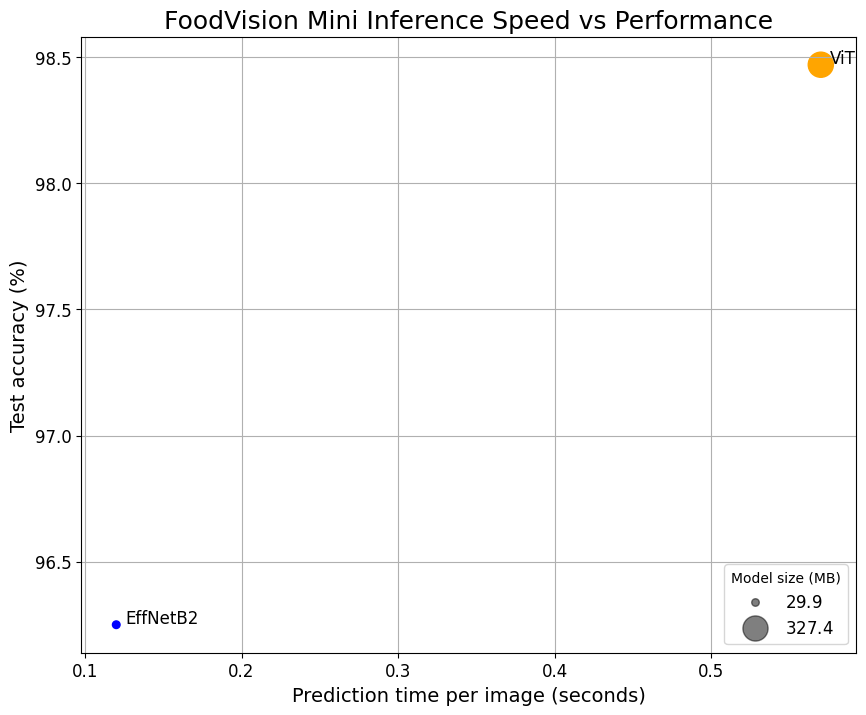

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(data=stats,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'],
                     s='model_size (MB)')

ax.set_title('FoodVision Mini Inference Speed vs Performance', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

for index, row in stats.iterrows():
  ax.annotate(text=index, xy=(row['time_per_pred_cpu'] + 6e-3, row['test_acc'] + 6e-3), size=12)

# Create a legend based on the model sizes (model_size (MB))
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title='Model size (MB)',
                              fontsize=12)

# Save the figure
plt.savefig('foodvision-mini-inference-speed-vs-performance.png')

In [ ]:
try:
  import gradio as gr
except:
  !pip install gradio
  import gradio as gr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.3 MB/s eta 0:00:00


In [ ]:
from typing import List, Dict, Tuple
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    preds = torch.softmax(effnetb2(img), dim=1)[0]

  pred_labels_and_probs = {class_names[i]:round(preds[i].item(), 4) for i in range(len(class_names))}

  end_time = timer()

  return pred_labels_and_probs, round(end_time - start_time, 4)



In [ ]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
path = random.choice(test_data_paths)
img = Image.open(path)

predict(img)

({'pizza': 0.1168, 'steak': 0.8696, 'sushi': 0.0136}, 0.1045)

In [ ]:
example_paths = random.sample(test_data_paths, k=3)
example_paths = [[str(path)] for path in example_paths]

### 7.4 Building a Gradio Interface

In [ ]:
# %%writefile demo/foodvision_mini/app.py

import gradio as gr

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type='pil'),
    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
             gr.Number(label='Prediction time (s)')],
    examples=example_paths,
    title='FoodMini Vision 🍕🥩🍣',
    description='Prediction from EffNetB2 transfer learning',
    article='Created at 09. PyTorch Model Deployment'
)

demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://558f7c144a102acb07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

To do this, we're going to prepare our app files so we can host them on Hugging Face Spaces

### 8.1 What is Hugging Face Spaces

### 8.2 Deploy Hugging Face app

### 8.3 Creating a demos

In [ ]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path('demo/foodvision_mini/')

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

!ls demo/foodvision_mini

In [ ]:
shutil.copy('effnetb2.pth', foodvision_mini_demo_path)
examples_dir = foodvision_mini_demo_path / 'examples'
examples_dir.mkdir(parents=True, exist_ok=True)
for path in [path[0] for path in example_paths]:
  shutil.copy(path, examples_dir)

In [ ]:
example_paths_gradio = [[x] for x in list(examples_dir.glob('*.jpg'))]

In [ ]:
%%writefile demo/foodvision_mini/model.py

import torch
import torchvision

def create_effnetb2_model(num_classes:int = 3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=weights)
  for param in effnetb2.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  effnetb2.classifier = torch.nn.Sequential(nn.Dropout(p=0.3),
                                            nn.Linear(1408, 3))

  return effnetb2, effnetb2_transforms


Writing demo/foodvision_mini/model.py


In [ ]:
%%writefile demo/foodvision_mini/app.py

import gradio as gr
from typing import List, Dict, Tuple
from timeit import default_timer as timer
from model import create_effnetb2_model
from pathlib import Path
import os

class_names = ['pizza', 'steak', 'sushi']
effnetb2, effnetb2_transform = create_effnetb2_model(len(class_names), 42)
effnetb2.load_state_dict(torch.load(f='demo/foodvision_mini/effnetb2.pth',
                                    map_location=torch.device('cpu')))

example_dir = Path('demo/foodvision_mini/examples')
example_paths = [[x] for x in os.listdir(examples_dir)]

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    preds = torch.softmax(effnetb2(img), dim=1)[0]

  pred_labels_and_probs = {class_names[i]:round(preds[i].item(), 4) for i in range(len(class_names))}

  end_time = timer()

  return pred_labels_and_probs, round(end_time - start_time, 4)


demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type='pil'),
    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
             gr.Number(label='Prediction time (s)')],
    examples=example_paths,
    title='FoodMini Vision 🍕🥩🍣',
    description='Prediction from EffNetB2 transfer learning',
    article='Created at 09. PyTorch Model Deployment'
)

demo.launch(debug=False,
            share=True)

Writing demo/foodvision_mini/app.py


In [ ]:
%%writefile demo/foodvision_mini/requirements.txt

torch==2.4.1
torchvision==0.19.1
gradio==4.44.0

Writing demo/foodvision_mini/requirements.txt


In [ ]:
torch.__version__, torchvision.__version__, gr.__version__

('2.4.1+cu121', '0.19.1+cu121', '4.44.0')

## 9. Deploying our FoodVision Mini app HuggingFace Spaces

### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces

In [ ]:
!ls demo/foodvision_mini

app.py	effnetb2.pth  examples	model.py  requirements.txt


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demo/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 49%)
  adding: effnetb2.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/1482489.jpg (deflated 1%)
  adding: examples/61656.jpg (deflated 0%)
  adding: examples/595836.jpg (deflated 1%)
  adding: model.py (deflated 50%)
  adding: requirements.txt (deflated 6%)


In [ ]:
# Download
try:
  from google.colab import files
  files.download('demo/foodvision_mini.zip')
except:
  print(f'Cannot download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo app locally

In [ ]:
from IPython.display import IFrame

IFrame(src='', width=900, height=750)

In [ ]:
effnetb2_101, effnetb2_101_transform = create_effnetb2_model(num_classes=101)
summary(effnetb2_101,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

In [ ]:
food_101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_101_transform
])

In [ ]:
food101_train = torchvision.datasets.Food101(root='data',
                                             split='train',
                                             transform=food_101_transforms,
                                             download=True)

food101_test = torchvision.datasets.Food101(root='data',
                                            split='test',
                                            transform=effnetb2_101_transform,
                                            download=True)

In [4]:
l = ['gnocchi', 'cheese_plate', 'ramen', 'ice_cream', 'donuts', 'cup_cakes', 'french_onion_soup', 'bruschetta', 'poutine', 'grilled_cheese_sandwich', 'grilled_salmon', 'chicken_curry', 'baby_back_ribs', 'crab_cakes', 'caprese_salad', 'strawberry_shortcake', 'garlic_bread', 'tuna_tartare', 'hummus', 'chocolate_mousse', 'tiramisu', 'huevos_rancheros', 'french_toast', 'samosa', 'peking_duck', 'beet_salad', 'spring_rolls', 'pizza', 'macarons', 'fish_and_chips', 'beignets', 'panna_cotta', 'beef_carpaccio', 'red_velvet_cake', 'foie_gras', 'clam_chowder', 'pulled_pork_sandwich', 'hamburger', 'lobster_bisque', 'spaghetti_bolognese', 'frozen_yogurt', 'macaroni_and_cheese', 'omelette', 'caesar_salad', 'croque_madame', 'chocolate_cake', 'pho', 'nachos', 'falafel', 'fried_calamari', 'chicken_wings', 'club_sandwich', 'mussels', 'lobster_roll_sandwich', 'risotto', 'breakfast_burrito', 'ravioli', 'edamame', 'chicken_quesadilla', 'baklava', 'bibimbap', 'pancakes', 'bread_pudding', 'guacamole', 'greek_salad', 'miso_soup', 'eggs_benedict', 'fried_rice', 'pad_thai', 'shrimp_and_grits', 'hot_and_sour_soup', 'deviled_eggs', 'cannoli', 'oysters', 'escargots', 'tacos', 'apple_pie', 'seaweed_salad', 'paella', 'carrot_cake', 'filet_mignon', 'churros', 'sushi', 'takoyaki', 'waffles', 'ceviche', 'cheesecake', 'dumplings', 'lasagna', 'sashimi', 'hot_dog', 'prime_rib', 'onion_rings', 'steak', 'creme_brulee', 'pork_chop', 'spaghetti_carbonara', 'french_fries', 'scallops', 'beef_tartare', 'gyoza']
s = '\n'.join(l)
print(s)

gnocchi
cheese_plate
ramen
ice_cream
donuts
cup_cakes
french_onion_soup
bruschetta
poutine
grilled_cheese_sandwich
grilled_salmon
chicken_curry
baby_back_ribs
crab_cakes
caprese_salad
strawberry_shortcake
garlic_bread
tuna_tartare
hummus
chocolate_mousse
tiramisu
huevos_rancheros
french_toast
samosa
peking_duck
beet_salad
spring_rolls
pizza
macarons
fish_and_chips
beignets
panna_cotta
beef_carpaccio
red_velvet_cake
foie_gras
clam_chowder
pulled_pork_sandwich
hamburger
lobster_bisque
spaghetti_bolognese
frozen_yogurt
macaroni_and_cheese
omelette
caesar_salad
croque_madame
chocolate_cake
pho
nachos
falafel
fried_calamari
chicken_wings
club_sandwich
mussels
lobster_roll_sandwich
risotto
breakfast_burrito
ravioli
edamame
chicken_quesadilla
baklava
bibimbap
pancakes
bread_pudding
guacamole
greek_salad
miso_soup
eggs_benedict
fried_rice
pad_thai
shrimp_and_grits
hot_and_sour_soup
deviled_eggs
cannoli
oysters
escargots
tacos
apple_pie
seaweed_salad
paella
carrot_cake
filet_mignon
churros
sush

In [ ]:
# Get class name variable
class_names = food101_train.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of Food101 dataset for faster experimenting



In [ ]:
len(food101_train) * 0.2, len(food101_test) * 0.2

(15150.0, 5050.0)

In [ ]:
type(food101_train[0]), food101_train[0][1], food101_train[0][0].shape

(tuple, 23, torch.Size([3, 288, 288]))

In [ ]:
# Get 20% of the
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  dataset_len = len(dataset)
  len1 = int(dataset_len * split_size)
  len2 = dataset_len - len1

  return random_split(dataset, [len1, len2], generator=torch.manual_seed(seed))

In [ ]:
traindata_101_20, _ = split_dataset(food101_train)
testdata_101_20, _ = split_dataset(food101_test)

len(traindata_101_20), len(testdata_101_20)

(15150, 5050)

In [ ]:
from torch.utils.data import DataLoader
import os

train101_dataloader = DataLoader(traindata_101_20, 32, shuffle=True, num_workers=2)
test101_dataloader = DataLoader(testdata_101_20, 32, shuffle=False, num_workers=2)

In [ ]:
optimizer = torch.optim.Adam(effnetb2_101.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
results_101 = engine.train(effnetb2_101,
                           train101_dataloader,
                           test101_dataloader,
                           optimizer,
                           loss_fn,
                           5,
                           device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4680 | train_acc: 0.2816 | test_loss: 2.4761 | test_acc: 0.4857
Epoch: 2 | train_loss: 2.5034 | train_acc: 0.4376 | test_loss: 2.0089 | test_acc: 0.5409
Epoch: 3 | train_loss: 2.2097 | train_acc: 0.4844 | test_loss: 1.8551 | test_acc: 0.5499
Epoch: 4 | train_loss: 2.0687 | train_acc: 0.5039 | test_loss: 1.7689 | test_acc: 0.5658
Epoch: 5 | train_loss: 1.9880 | train_acc: 0.5167 | test_loss: 1.7085 | test_acc: 0.5838


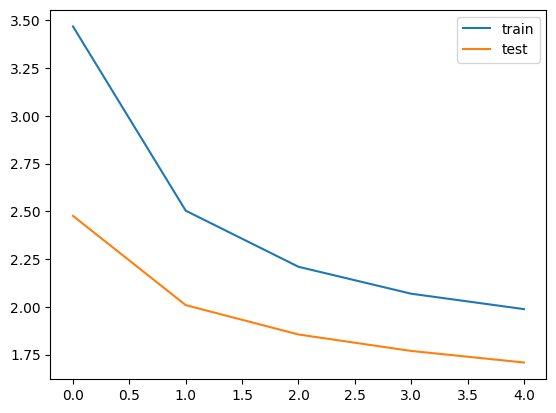

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0, 5), results_101['train_loss'], label='train')
plt.plot(range(0, 5), results_101['test_loss'], label='test')
plt.legend()

In [ ]:
torch.save(effnetb2_101.state_dict(), 'effnetb2_101.pth')

In [ ]:
test_101_model, _ = create_effnetb2_model(101)
test_101_model.load_state_dict(torch.load('effnetb2_101.pth'))

<ipython-input-25-b5a6c9f4ec9b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_101_model.load_state_dict(torch.load('effnetb2_101.pth'))


<All keys matched successfully>

In [ ]:
from pathlib import Path
size_101 = Path('effnetb2_101.pth').stat().st_size // (1024 * 1024)
print(f'Size 101 (MB) = {size_101} (MB)')

Size 101 (MB) = 30 (MB)


### 10.4 Big model app file

In [ ]:
big_dir = Path('demos/foodvision_big')
if big_dir.exists():
  os.rmtree(big_dir)
big_dir.mkdir(parents=True, exist_ok=True)

examples_dir = big_dir / 'examples'
examples_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
import requests

response = requests.get('https://static.vecteezy.com/system/resources/previews/021/027/415/non_2x/apple-pie-transparent-png.png')
with open(examples_dir / 'apple_pie_1.png', 'wb') as f:
  f.write(response.content)

In [ ]:
import shutil
shutil.move('effnetb2_101.pth', big_dir)

'demos/foodvision_big/effnetb2_101.pth'

In [ ]:
with open('class_names.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
with open('class_names.txt', 'r') as f:
  cn = f.readlines()
cn = [x.strip() for x in cn]
cn

In [ ]:
%%writefile demos/foodvision_big/model.py

import torch
import torchvision

def create_effnetb2_model(num_classes:int = 3,
                          seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=weights)
  for param in effnetb2.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  effnetb2.classifier = torch.nn.Sequential(nn.Dropout(p=0.3),
                                            nn.Linear(1408, num_classes))

  return effnetb2, effnetb2_transforms


Writing demos/foodvision_big/model.py


In [ ]:
%%writefile demos/foodvision_big/app.py

import gradio as gr
from typing import List, Dict, Tuple
from timeit import default_timer as timer
from model import create_effnetb2_model
from pathlib import Path
import os

with open('class_names.txt', 'r') as f:
  class_names = [x.strip() for x in f.readlines()]

effnetb2, effnetb2_transform = create_effnetb2_model(len(class_names), 42)
effnetb2.load_state_dict(torch.load(f='demos/foodvision_big/effnetb2_101.pth',
                                    map_location=torch.device('cpu')))

example_dir = Path('examples')
example_paths = [[x] for x in os.listdir(examples_dir)]

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    preds = torch.softmax(effnetb2(img), dim=1)[0]

  pred_labels_and_probs = {class_names[i]:round(preds[i].item(), 4) for i in range(len(class_names))}

  end_time = timer()

  return pred_labels_and_probs, round(end_time - start_time, 4)


demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type='pil'),
    outputs=[gr.Label(num_top_classes=101, label='Predictions'),
             gr.Number(label='Prediction time (s)')],
    examples=example_paths,
    title='FoodMini Vision Big 🧐',
    description='Prediction from EffNetB2 transfer learning 101 classes',
    article='Created at 09. PyTorch Model Deployment'
)

demo.launch(debug=False)

Overwriting demos/foodvision_big/app.py


In [ ]:
%%writefile demos/foodvision_big/requirements.txt

torch==2.4.1
torchvision==0.19.1
gradio==4.44.0

Writing demos/foodvision_big/requirements.txt


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 49%)
  adding: effnetb2_101.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/apple_pie_1.png (deflated 62%)
  adding: model.py (deflated 51%)
  adding: requirements.txt (deflated 6%)


In [ ]:
from google.colab import files

try:
  files.download('demos/foodvision_big.zip')
except:
  print('cannot download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>